# <center>Выявление диабета у женщин по анализу данных об их здоровье</center>

**В задании (https://www.openml.org/d/37) предлагается решить задачу классификации диабета по медицинским данным.**

Описание признаков:
- age: возраст.
- preg: кол-во перенесенных беременностей.
- plas: концентрация глюкозы в плазме.
- pres: артериальное давление.
- skin: толщина кожной складки трицепса (мм).
- insu: кол-во инсулина.
- mass: индекс массы тела.
- pedi: значение функции, которое было расчитано на основании данных о болевших диабетом генетических родственников пациента.
- class: tested_positive - выявлен диабет, tested_negative - не выявлен диабет.

In [59]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [126]:
data = pd.read_csv('dataset_37_diabetes.csv')
data.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive


**1. Заменим для удобства отображение класса на числовой формат**

In [68]:
labels = data['class'].unique().tolist()
mapping = dict( zip(labels,range(len(labels))) )
data.replace({'class': mapping},inplace=True)
data.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,0
1,1,85,66,29,0,26.6,0.351,31,1
2,8,183,64,0,0,23.3,0.672,32,0
3,1,89,66,23,94,28.1,0.167,21,1
4,0,137,40,35,168,43.1,2.288,33,0


**2. Посмотрим как количество перенесенных беременностей влияет на диабет?**

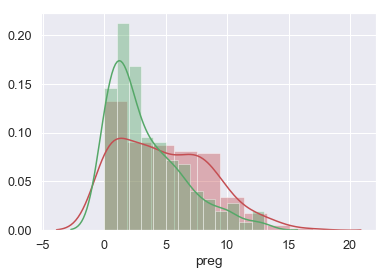

In [82]:
sns.distplot(data[data['class']==0]['preg'], color="r");
sns.distplot(data[data['class']==1]['preg'], color="g");

**2. Может ли наличие диабета у родственников указывать на предрасположенность к диабету у пациента?**

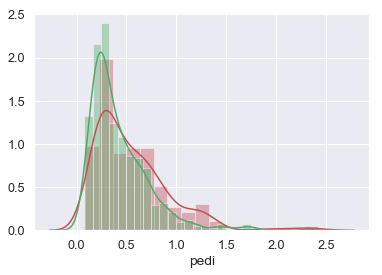

In [86]:
sns.distplot(data[data['class']==0]['pedi'], color="r");
sns.distplot(data[data['class']==1]['pedi'], color="g");

**3. Убедимся в том, что повышенный уровень глюкозы в крови влияет на риск диабета**

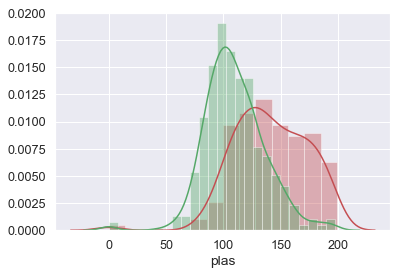

In [81]:
sns.distplot(data[data['class']==0]['plas'], color="r");
sns.distplot(data[data['class']==1]['plas'], color="g");

**4. Построим матрицу корреляций, чтобы убедиться в независимости признаков. Еще раз убеждаемся, что основной признак диабета - повышенный уровень глюкозы в крови**

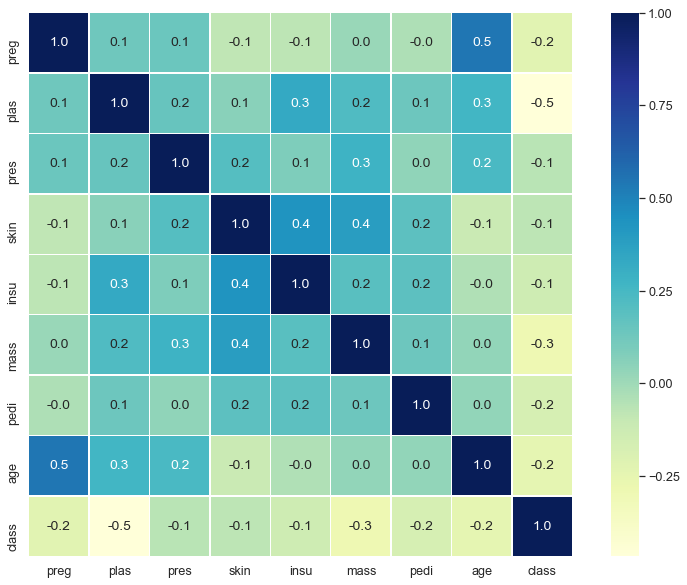

In [83]:
sns.set(font_scale = 1.15)
plt.figure(figsize = (14, 10))
sns.heatmap(data.corr(), vmax = 1, linewidths = 0.5, fmt= '.1f',
            square = True, annot = True, cmap = 'YlGnBu', linecolor = "white")

**6. Создаем тренировочную выборку**

In [89]:
x = np.array(data.iloc[:,[x for x in range(0, 8)]])
y = np.array(data["class"])

**7. Попробуем использовать логистическую регрессию для предсказания диабета.**

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

lr = LogisticRegression(random_state=5, class_weight= 'balanced', solver='lbfgs', max_iter= 500)
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

In [113]:
grid = GridSearchCV(lr, parameters, n_jobs=-1, scoring ='roc_auc', cv=skf)
grid = grid.fit(X, y)
grid.best_estimator_

LogisticRegression(C=10, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=500,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=5,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [114]:
grid.best_score_

0.8319480567930352

**8. Попытаемся использовать Random Forest для нашей задачи классификации.**

In [118]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами 
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, 
                            random_state=42, oob_score=True, 
                            class_weight='balanced')

## Будем искать лучшие параметры среди следующего набора
parameters = {'max_features': [1, 2, 4], 
              'min_samples_leaf': [3, 5, 7, 9], 
              'max_depth': [5,10,15]}

In [123]:
%%time
rf_grid = GridSearchCV(rf, parameters, n_jobs=-1, scoring ='roc_auc', cv=skf,
                             verbose=True)
rf_grid = rf_grid.fit(x, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.7s


Wall time: 17.7 s


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   17.4s finished


In [124]:
tree_predictions = rf_grid.predict(x)
accuracy_score(y,tree_predictions)

0.828125

**9. Посмотрим какой признак оказал наименьшее влияние.**

In [125]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'class']
independent_columns_names[np.argmin(rf_grid.best_estimator_.feature_importances_)]

'skin'